In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline


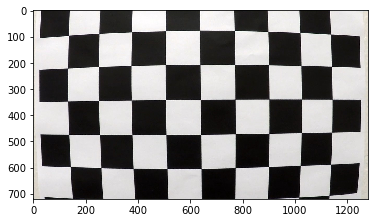

In [2]:
#read the calibration images
img = mpimg.imread('.\camera_cal\calibration1.jpg')
plt.imshow(img)

.\camera_cal\calibration1.jpg False
.\camera_cal\calibration10.jpg True
.\camera_cal\calibration11.jpg True
.\camera_cal\calibration12.jpg True
.\camera_cal\calibration13.jpg True
.\camera_cal\calibration14.jpg True
.\camera_cal\calibration15.jpg True
.\camera_cal\calibration16.jpg True
.\camera_cal\calibration17.jpg True
.\camera_cal\calibration18.jpg True
.\camera_cal\calibration19.jpg True
.\camera_cal\calibration2.jpg True
.\camera_cal\calibration20.jpg True
.\camera_cal\calibration3.jpg True
.\camera_cal\calibration4.jpg False
.\camera_cal\calibration5.jpg False
.\camera_cal\calibration6.jpg True
.\camera_cal\calibration7.jpg True
.\camera_cal\calibration8.jpg True
.\camera_cal\calibration9.jpg True


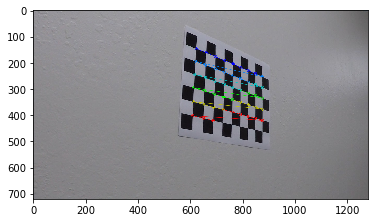

In [3]:
#read in the camera calibration images
images = glob.glob('.\camera_cal\calibration*.jpg')
# Array to store object points and image points for all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points im image plane
#prepare object points like (0,0,0), (0,0,1), ..(7,5,0)
objp = np.zeros((6*9,3),np.float32)
objp[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates
for fname in images:
    #read the image
    img = mpimg.imread(fname)
    #Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    print(fname, ret)
    #if corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw and display the corners
        img = cv2.drawChessboardCorners(img,(8,6),corners,ret)
        plt.imshow(img)


In [4]:
#Camera calibration, given object points, image points, and the shape of the grayscale image:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# SAVE THE CAMERA CALIBRATION RESULT FOR LATER USE
dist_pickle = {}
dist_pickle["mtx"]=mtx
dist_pickle["dist"]=dist
pickle.dump(dist_pickle,open("./calibration_pickle.p", "wb"))


In [5]:
#Undistorting an image:
i= 1
for fname in images:
    #read the image
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #outfile = '.\output_images\calibration_undist' + str(i)+'.jpg'
    outfile = '.\output_images\calibration_undist' + str(i) + '.jpg'
    mpimg.imsave(outfile, dst)
    i +=1

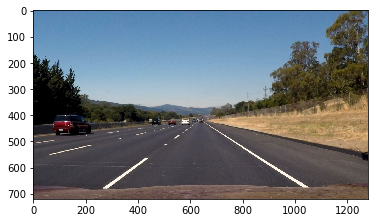

In [6]:
# Create a list of non-car images
testimages = glob.glob('./test_images/*jpg')

images = []

for image in testimages:
    images.append(image)
    
image = mpimg.imread(images[1])
#image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(image)

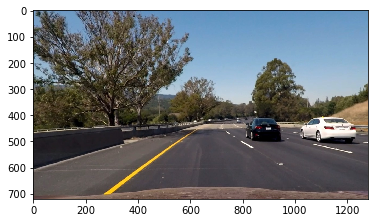

In [7]:
#Undistorting an image:
i=0
for image in images:
    img = mpimg.imread(image)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #out_testfile = '.\output_images\undist' + str(i) + '.jpg'
    out_testfile = './output_images/undist' + str(i) + '.jpg'
    mpimg.imsave(out_testfile, dst)
    i +=1

plt.imshow(dst)

In [8]:


def pipeline_old(img, s_thresh=(90, 255),v_thresh=(90, 255), sx_thresh=(12, 255), sy_thresh=(60, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    #preprocessimage = np.zeros_like(img[:,:,0])
    #gradx = abs_sobel_threshold
   
    # Sobel x
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img[:,:,0]
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(sybinary ==1) & (sxbinary==1)]= 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    v_binary=np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    output0 = np.zeros_like(s_channel)
    output0[(s_binary ==1) & (v_binary==1)]= 1
    output = np.zeros_like(s_channel)
    output[(output0 ==1) & (sxbinary==1)]= 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxybinary, output0))
   
    return color_binary




In [9]:
def pipiline(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(your_image, (200,200,200), (255,255,255))

    bit_layer = your_bit_layer | yellow | white | white_2 | white_3
    color_binary = np.dstack((np.zeros_like(img), bit_layer, bit_layer))
   
    return color_binary

In [10]:

testimages = glob.glob('./output_images/undist*.jpg')

images = []

i=0
for fname in testimages:
    images.append(fname)
    ing = mpimg.imread(fname)
    reslt = pipeline(ing)
    outfile = './output_images/pipeline' + str(i)+'.jpg'
    mpimg.imsave(outfile, reslt)
    i +=1
print(images)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(ing)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(reslt)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

NameError: name 'pipeline' is not defined

In [ ]:



def corners_unwarp(image, mtx, dist):

    offset = 0 # offset for dst points
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])
    bot_width = 0.76 # percent of bottom trapezoid height
    mid_width = 0.08 # percent of middle trapezoid height
    height_pct = 0.62 # percent of trapezoid height
    bottom_trim = 0.935 # percent from top to bottom to avoid hood

    src = np.float32([[img_size[0]*(0.5-mid_width/2),img_size[1]*height_pct],
                      [img_size[0]*(0.5+mid_width/2),img_size[1]*height_pct],
                      [img_size[0]*(0.5+bot_width/2),img_size[1]*bottom_trim],
                      [img_size[0]*(0.5-bot_width/2),img_size[1]*bottom_trim]])
    offset = img_size[0]*.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()

    warped = cv2.warpPerspective(image, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

testimages = glob.glob('./output_images/pipeline*.jpg')

images = []
M =[]
MINV =[]
i=0
for fname in testimages:
    inage =cv2.imread(fname)

    top_down, perspective_M, Minv = corners_unwarp(inage, mtx, dist)
    outfile = './output_images/top_down' + str(i)+'.jpg'
    M.append(perspective_M)
    MINV.append(Minv)
    mpimg.imsave(outfile, top_down)
    i +=1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(inage)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Top View Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.window_centroids = [] 

        #left_fitx values
        self.left_fitx = None     
        #right_fitx
        self.right_fitx = None  
        
        #radius of curvature of the line in some units
        self.left_curverad = 0.0 
        self.right_curverad = 0.0 
        #difference in fit coefficients between last and new fits
        self.car_offset = 0.0
        

In [ ]:
class tracker():
    def __init__(self, Mywindow_height,Mywindow_width, Mymargin, My_ym = 1, My_xm = 1,Mysmooth_factor = 30):
        # 
        # list that stores all the past (left, right) centeer set values used for smoothing the output
        self.recent_centers = []
        # the window pixel width of the center values, used to count pixels inside center windows to determine curve values
        self.window_width = Mywindow_width
        # the window pixel height of the center values
        self.window_height = Mywindow_height
        
        # the pixel ditance in both  directions to slide
        self.margin = Mymargin
        self.ym_per_pix = My_ym # meters per pixel in vertical axis
        self.xm_per_pix = My_xm # meters per pixel in x axis
        self.smooth_factor = Mysmooth_factor
        

In [ ]:
current = Line()
previous = Line()
track = tracker(Mywindow_width = 40, Mywindow_height = 80, Mymargin = 40)


In [ ]:
from PIL import ImageDraw, Image 
# Read in a thresholded image

# window settings
window_width = 40 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def do_once (image, window_width, window_height, margin):
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int((3*image.shape[0]/4)):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    histogram = np.sum(image, axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if leftx_base >450 or leftx_base <380:
        leftx_base = 405
    if rightx_base <875 or rightx_base > 100:
        rightx_base = 945
    if l_center >450 or l_center <360:
        l_center = leftx_base
    if r_center <875 or r_center > 975:
        r_center = rightx_base
    return l_center, r_center

def find_window_centroids(image, window_width, window_height, margin, l_center, r_center, average):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    rect_window = []
    lane_center = (l_center +r_center)/2
    car_offset = int((image.shape[1]/2)-lane_center)
    good_left = 0
    good_right = 0
    balanced_center = 0
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    last_left = l_center
    last_right = r_center


    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image

        
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
               
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center-offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        valid_l = np.argmax(conv_signal[l_min_index:l_max_index])>40
        l_argmax = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_pt1=(l_min_index, int(image.shape[0]-(level)*window_height))
        l_pt2=(l_max_index, int(image.shape[0]-(level+1)*window_height))
          
       
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center-offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        valid_r = np.argmax(conv_signal[r_min_index:r_max_index])>40
        r_argmax = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        r_pt1=(r_min_index,int(image.shape[0]-(level)*window_height))
        r_pt2=(r_max_index,int(image.shape[0]-(level+1)*window_height))
        if average:
            if valid_l:
                l_center = l_argmax
                good_left +=1
            if valid_r:
                good_right +=1
                r_center = r_argmax
            if not(valid_l):
                if valid_r:
                    l_center = r_argmax-515
                else:
                    l_center = last_left
            if not(valid_r):
                if valid_l:
                    r_center = l_center+515
        else:
            l_center = l_argmax
            r_center = r_argmax
            

        #if r_center >l_center + 515:
        #    r_center = l_center+515
        #if r_center <l_center + 490:
        #    r_center = l_center+490
        diff_center = r_center-l_center
        if diff_center >475 and diff_center <525:
            balanced_center +=1
        
        
        # Add what we found for that layer
        rect_window.append((l_pt1,l_pt2,r_pt1,r_pt2))
        last_left = l_center
        window_centroids.append((l_center,r_center))
    centroid_good =  (good_left >4 or good_right >4) and balanced_center >6
    if average:
        if previous.detected and not(centroid_good): #Not First Iteration and bad values
            window_centroids = previous.window_centroids
    
        if centroid_good:
            current.window_centroids = window_centroids
            current.detected = True
        
        if not(previous.detected):
            current.window_centroids = window_centroids
            previous.window_centroids = window_centroids 
    else:
        current.window_centroids = window_centroids
        previous.window_centroids = window_centroids
    
    #return averaged valuesof the line centers, helps to keep the markers from jumping around too much
    if average:
        track.recent_centers.append(window_centroids)
        return np.average(track.recent_centers[-track.smooth_factor:], axis =0), rect_window, car_offset
    else:
        return window_centroids, rect_window, car_offset



In [ ]:
def centroids(img, window_width, window_height, margin,dst, Minv, average):
    #img2 = astype(numpy.uint8)
    image = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)

    l_center, r_center = do_once(image, window_width, window_height, margin)

    window_centroids, rect_window, car_offset = find_window_centroids(image, window_width, window_height, margin, l_center, r_center, average)
 
    left_lane_inds = []
    right_lane_inds = []
    x_points = []
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    width = 0
    # If we found any window centers
    if len(window_centroids) > 0:
    
        for level in range(0,len(window_centroids)):
            # Identify the nonzero pixels in x and y within the window
            left_lane_inds.append(window_centroids[level][0])
            right_lane_inds.append(window_centroids[level][1])
            width += (window_centroids[level][1])-(window_centroids[level][0])
            x_points.append((8-level)*window_height+72)
        
        left_fit = np.polyfit(x_points, left_lane_inds, 2)
        right_fit = np.polyfit(x_points, right_lane_inds, 2)
        width = width/8
        
        # Polygon fit right and left
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        current.left_fitx = left_fitx
        current.right_fitx = right_fitx
        # if it is a video average = true, then check polygon shapes of previous and current frames
        if average:
            if not(previous.detected): #or current.detected or (not(current.detected) and previous.detected):
                previous.left_fitx = left_fitx
                previous.right_fitx = right_fitx
            if previous.detected:
                a_left = previous.left_fitx
                a_right = previous.right_fitx
                b_left = current.left_fitx
                b_right = current.right_fitx
                ret_left = cv2.matchShapes(a_left, b_left,1,0.0)
                ret_right = cv2.matchShapes(a_right, b_right,1,0.0)
                if (ret_left <0.045 and ret_right<0.045):
                    previous.left_fitx = left_fitx
                    previous.right_fitx = right_fitx
                else:
                    left_fitx = previous.left_fitx
                    right_fitx = previous.right_fitx
       
        yvals = range(0,image.shape[0])
        left_lane =np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),
                                     np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        right_lane =np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),
                                     np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/(720*.935) # meters per pixel in y dimension, the point of interest is taken at .935 in warping
        xm_per_pix = 3.7/width # meters per pixel in x dimension
        if average:
            if not(previous.detected):
                car_offset_meters = xm_per_pix * car_offset
                current.car_offset = car_offset_meters
            if current.detected and previous.detected:
                # average the offset over 20 frames
                car_offset_meters = xm_per_pix * car_offset+ ((xm_per_pix * car_offset)-previous.car_offset)/20
                current.car_offset = car_offset_meters
            if not(current.detected) and previous.detected:
                current.car_offset = previous.car_offset
        else:
            car_offset_meters = xm_per_pix * car_offset 
            

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)/2
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

        
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
       
        
        # Now our radius of curvature is in meters
        bad_curve = (left_curverad > right_curverad +100 or left_curverad <right_curverad -100) or (left_curverad<400 or right_curverad<400)
        if average:
            if bad_curve and previous.detected:
                current.left_curverad = previous.left_curverad
                current.right_curverad = previous.right_curverad
            if not(bad_curve) and previous.detected:
                current.left_curverad = previous.left_curverad+ (left_curverad-previous.left_curverad)/20
                current.right_curverad = previous.right_curverad +(right_curverad-previous.right_curverad)/20
        else:
            current.left_curverad = left_curverad
            current.right_curverad = right_curverad
            previous.left_curverad = left_curverad
            previous.right_curverad = right_curverad
            
            
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(img).astype(np.uint8)
        warp2_zero = np.zeros_like(img).astype(np.uint8)
        
        color_warp = warp_zero
        smallimg=[]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        
        if average:
            if not(previous.detected): #First Iteration
                previous.detected = True
                previous.left_fitx = left_fitx
                previous.right_fitx = right_fitx
                previous.left_curverad = left_curverad
                previous.right_curverad = right_curverad
                previous.car_offset = car_offset_meters
            
                current.left_fitx = left_fitx
                current.right_fitx = right_fitx
                current.left_curverad = left_curverad
                current.right_curverad = right_curverad
                current.car_offset = car_offset_meters
        
        curverad = (current.left_curverad+current.right_curverad)/2
        
        
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        for level in range(0,len(rect_window)):
            cv2.rectangle(color_warp,(rect_window[level][0]),(rect_window[level][1]),color=(255,0,0), thickness=10)
            cv2.rectangle(color_warp,(rect_window[level][2]),(rect_window[level][3]),color=(255,0,0), thickness=10)

        
        result0 = cv2.addWeighted(img.astype(np.uint8), 1, color_warp, 0.3, 0)
        
        color2_warp = warp2_zero

        cv2.fillPoly(color2_warp, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(color2_warp,[left_lane], color = [255,0,0])
        cv2.fillPoly(color2_warp,[right_lane], color = [255,0,0])
        newwarp = cv2.warpPerspective(color2_warp, Minv, (img.shape[1], img.shape[0]))
        smallimg = cv2.resize(color2_warp,(128,72))

        x_offset= 1100
        y_offset= 100
        newwarp[y_offset:y_offset+smallimg.shape[0], x_offset:x_offset+smallimg.shape[1]] = smallimg
        # Combine the result with the original image

        result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)
        lanecur = 'Lane Curvature is '+ str(curverad)
        car_steer = 'Car_offset is ' + str(current.car_offset)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,lanecur,(10,20), font, 1,(255,255,255),2)
        cv2.putText(result,car_steer,(10,50), font, 1,(255,255,255),2)
        
        #update previous line and clear current_line
        previous.left_fitx = current.left_fitx
        previous.right_fitx = current.right_fitx
        previous.left_curverad = current.left_curverad
        previous.right_curverad = current.right_curverad
        previous.car_offset = current.car_offset
        previous.window_centroids = current.window_centroids
        current.detected = False
        
    else:
        result0 = img
        result = dst
    return result, result0

    

    

  


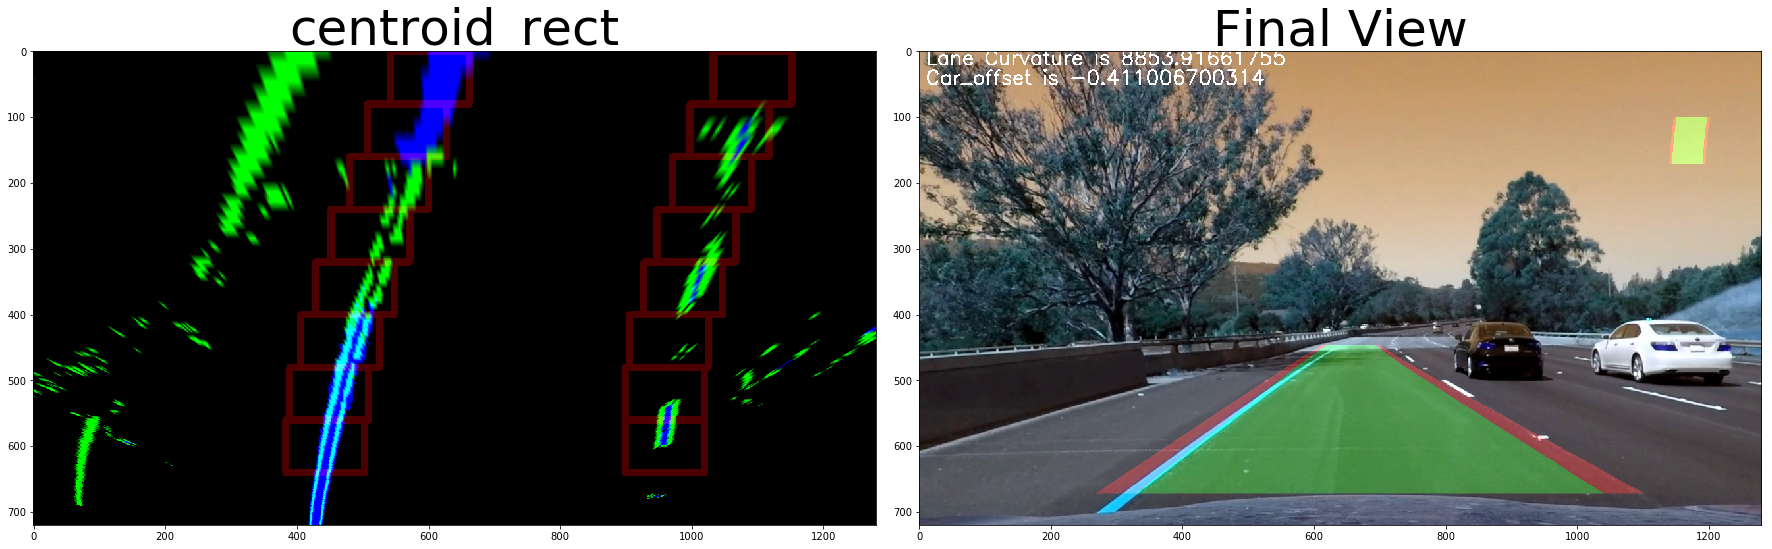

In [66]:
testimages = glob.glob('./output_images/top_down*.jpg')
dstimages = glob.glob('./output_images/undist*.jpg')
images = []
i=0





for fname in testimages:
    img = cv2.imread(testimages[i])

    dst = cv2.imread(dstimages[i])
    Minv = MINV[i]
    result, result0 = centroids(img,window_width, window_height, margin,dst, Minv, average = "False")
    outfile = './output_images/final' + str(i)+'.jpg'
    mpimg.imsave(outfile, result)
    outfile2 = './output_images/win_centroid' + str(i)+'.jpg'
    mpimg.imsave(outfile2, result0)
    i +=1
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result0)
ax1.set_title('centroid_rect', fontsize=50)

ax2.imshow(result)
ax2.set_title('Final View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [67]:
#For video
# Video Pipeline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [68]:
def process_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    reslt = pipeline(img)

    top_down, perspective_M, Minv = corners_unwarp(reslt, mtx, dist)
  
    result, result0 = centroids(top_down,window_width, window_height, margin,img, Minv, average = True)
    return result

In [69]:


white_output = 'project_marked_lanes.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_marked_lanes.mp4
[MoviePy] Writing video project_marked_lanes.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:48<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_marked_lanes.mp4 

Wall time: 6min 51s


In [70]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>-
""".format(white_output))